# Model-Based Collaborative Filtering : SVD and Baseline ALS

In this notebook, I will be using Singular Value Decomposition(SVD) and Alternating Least Squares(ALS) prediction algorithms to make video game recommendations to Playstation 4 users.

These models will be built using the python Surprise package.

https://surprise.readthedocs.io/en/stable/ : Python Surprise Documentation

The user review data used in this notebook has been obtained from a popular video game review site called Metacritic.

# Preparing the train-validation-test sets

Importing the essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from Utilities import custom_data_preprocess

In [2]:
#Importing the dataset that we will be working with
data = pd.read_csv("metaUserItemAnon.csv")

In [3]:
data.head()

,User_Name,Red Dead Redemption 2,Grand Theft Auto V,Persona 5 Royal,The Last of Us Remastered,God of War,The Last of Us Part II,Persona 5,Metal Gear Solid V: The Phantom Pain,Uncharted 4: A Thief's End,...,Dawn of Fear,Weeping Doll,Tony Hawk's Pro Skater 5,Dino Dini's Kick Off Revival,Ghostbusters,Air Conflicts: Vietnam Ultimate Edition,The Quiet Man,Basement Crawl,Road Rage,Afro Samurai 2: Revenge of Kuma Volume One
0,User 9414,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,User 80765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,User 51700,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,User 51358,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,User 11752,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Melting the user item matrix into a 3 column dataframe and dropping the cells that have not been rated yet
#The three columns will contain the users, games, and ratings respectively
data = pd.melt(data, id_vars = ["User_Name"])
modelData = data.dropna()
modelData = modelData.rename({'variable': 'Game_Name', 'value': 'Rating'}, axis=1)
modelData.head()

,User_Name,Game_Name,Rating
6,User 293,Red Dead Redemption 2,10.0
11,User 801,Red Dead Redemption 2,1.0
36,User 1120,Red Dead Redemption 2,10.0
145,User 2314,Red Dead Redemption 2,10.0
184,User 2869,Red Dead Redemption 2,9.0


Implementing feature scaling and Mean normalization. After this step the ratings will have 0 mean and the data will be symmetrical.
This will improve the quality of recommendations made by the model by helping it to converge and learn faster.

As you will see after the next step, the ratings will be modified to have 0 Mean and will be scaled to the range [0, 1].

In [5]:
max_rating = max(modelData["Rating"])
min_rating = min(modelData["Rating"])
range_ = max_rating - min_rating

#For each rating, subtract the minimum rating in the dataset and divide by the range of ratings.
modelData["Rating"] =  (modelData["Rating"] - min_rating) / range_

modelData.head()

,User_Name,Game_Name,Rating
6,User 293,Red Dead Redemption 2,1.0
11,User 801,Red Dead Redemption 2,0.1
36,User 1120,Red Dead Redemption 2,1.0
145,User 2314,Red Dead Redemption 2,1.0
184,User 2869,Red Dead Redemption 2,0.9


Lastly, we need to form the train, cross-validation, and test sets. 

We will form the train:val:test sets with an 80:10:10 split (approx). 

There are a few ways the dataset can be split, and the choice depends on what the application aims to achieve. For instance, if I want to avoid encountering a cold-start problem (arises when there exists new users who have not rated any game), I would ensure that my training set contains ratings from every single user and ratings of every single game. 

However, if I want to portray how well my application deals with new users that have no rating history, then I could use random initialization or a combination of random initialization and the above mentioned method to ensure that some users are not included in the training set, but are included in the test set. The former method is a little tricky, while the latter can be achieved by simply using the train_test_split function from the surprise package.

In my case, I will use the former split for two reasons. One, the dataset is already very sparse with majority of the users having rated only a single game, hence I do not want to include dealing with a cold start problem with insufficient data. And two, using this method could improve the recommendations for existing users.

I have included the functions I will use in order to perform this split in the Utilties folder under data_preprocess.py . Note that these functions aren't my own work. I will also link the source below.

https://gist.github.com/tgsmith61591/ce7d614d7a0442f94cd5ae5d1e51d3c2 - Written by Taylor G. Smith

Github Profile : https://gist.github.com/tgsmith61591

I recommend reading the documentation of all the functions in order to understand how it works in general and in the context of this application.

The above mentioned functions for splitting the data requires that we encode the usernames and game names before the data is passed into it.

I have written a function in the Utilities folder that will create encodings the users and items, retrieve the training and test sets by calling the train_test_split_cf method with the encoded data, and then replace the encodings with the original string values after the data has been split. The function will return two dataframes with the specified split size.

In [8]:
#Train-test split
trainset_full, testset = custom_data_preprocess.split_dataset(modelData, train_size = 0.9)

#Train-validation split
trainset, validset = custom_data_preprocess.split_dataset(trainset_full, train_size = 0.8)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
trainset.head()

,User_Name,Game_Name,Rating
0,User 293,Red Dead Redemption 2,1.0
1,User 801,Red Dead Redemption 2,0.1
2,User 1120,Red Dead Redemption 2,1.0
3,User 2314,Red Dead Redemption 2,1.0
4,User 2869,Red Dead Redemption 2,0.9


In [10]:
testset.head()

,User_Name,Game_Name,Rating
5,User 172,Red Dead Redemption 2,0.3
61,User 2362,Red Dead Redemption 2,0.9
64,User 576,Red Dead Redemption 2,0.4
65,User 119,Red Dead Redemption 2,0.7
66,User 1891,Red Dead Redemption 2,1.0


In [11]:
#Concatenating the train and validation set for use in GridSearchCV(), which will be introduced later
train_valid = pd.concat([trainset, validset])

Now that we have our final datasets, we can start using the surprise package to make recommendations. We begin by passing it through the reader defined within the package. This converts the dataframe into the required format to apply the matrix factorization models.

The rating scale of our model can be initialized to the range (0,1) since all our ratings now lie in this range.

In [12]:
#Declaring the reader object under the surprise package to specify the rating scale
reader = Reader(rating_scale=(0, 1))

#trainset needs to be converted to surprise trainset format
trainset = Dataset.load_from_df(trainset[['User_Name', 'Game_Name', 'Rating']], reader)

#testset needs to be converted to surprise testset format
testset = Dataset.load_from_df(testset[['User_Name', 'Game_Name', 'Rating']], reader)

#validset is in final format needed for cross validation
validset = Dataset.load_from_df(validset[['User_Name', 'Game_Name', 'Rating']], reader)

#Final dataset we will be using to train using GridSearchCV
train_valid = Dataset.load_from_df(train_valid[['User_Name', 'Game_Name', 'Rating']], reader)

#Converting testset to surprise testset format, this will be the final set used for testing
testset = testset.build_full_trainset()
testset = testset.build_testset()

#training set in surprise trainset format, will be used for model training
trainset = trainset.build_full_trainset()

# Singular Value Decomposition (SVD)

In this section we will run through the details and selection of hyperparameters such as the Learning Rate (alpha), Regularization (lambda), and the number of iterations for convergence (epochs) as well as the implementation of SVD for collaborative filtering.

We can begin to train our model using different values for the hyperparameters. At each choice learning curves will be plotted visualize how the error increases or decreases at different values of each parameter. This will 
help us choose the values that minimizes validation RMSE(error).

In order to choose these values, we can start at a good estimate for the hyperparameter and increase the value in multiples of 2 or 3 at every iteration. 

Such a process will take a lot of time to complete for a large dataset. Hence hyperparameter selection is usually only carried out once and then the values are saved to be used during the next run of the model. This way of manually doing it is helpful when it comes to visualizing and tweaking our hyperparameters, hence this is what I will primarily focus on.

In case you just want to find the best combination of hyperparameters to use automatically, the surprise package has a function that will do all the work for you, called GridSearchCV(). We can simply specify the range of values for each hyperparameter and pass it through the function, and it will return the combination of values that minimizes validation error. However, when using a large number of values this method becomes computationally expensive and time consuming, especially in the case of the SVD prediction algorithm.

Below I will run through the process of manually selecting hyperparameters for the model.

In [13]:
#this is only included to visualize how well the model performs on the training set
train_dict = trainset.build_testset()

#### Choosing the learning rate

The learning rate determines the step size taken at each iteration of the algorithm. If the algorithm deals with walking down a hill, the learning rate would define how large each step would be when walking downhill. The bottom of the hill is the point of minimum error(convergence). Hence the learning rate determines how long it would take to reach this point.

If the learning rate is too small the algorithm will require a larger number of iterations to converge, and if the learning rate is too large, the algorithm may overstep the minimum error value and never converge. The optimal learning rate lies in between these values.

By definition, although the learning rate remains constant in this case, the step size will still slowly decrease towards convergence. So choosing a learning rate that is too small may also never converge.

In [14]:
#Choosing the learning rate manually

#list of values that we will choose from
alpha_params = [0.0001, 0.0003, 0.0009, 0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1, 0.3, 0.9]

#list of validation errors that will be accumulated and plotted
errors = []

#list of trainset errors that will be accumulated and plotted
train_errors = []

for i in alpha_params:
    algo = SVD(n_epochs = 25, lr_all = i)
    algo.fit(trainset)
    train_predictions = algo.test(train_dict)
    train_errors.append(accuracy.rmse(train_predictions))
    
    #Testing the algorithm on the cross validation sets using 5 fold cross validation
    results = cross_validate(algo, validset, measures=['RMSE'], cv=5, verbose=False)
    results = results["test_rmse"]
    avgError = 0
    for value in results:
        avgError = avgError + value
    avgError = avgError / 5
    
    errors.append(avgError)

RMSE: 0.3618
RMSE: 0.3513
RMSE: 0.3377
RMSE: 0.3363
RMSE: 0.3102
RMSE: 0.2579
RMSE: 0.2509
RMSE: 0.1587
RMSE: 0.1117
RMSE: 0.1091
RMSE: 0.1067
RMSE: 0.5699


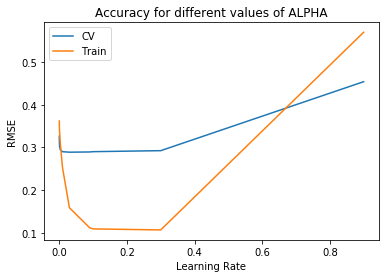

In [15]:
#Visualizing the train and validation error of the model with respect to learning rate
plt.plot(alpha_params, errors)
plt.plot(alpha_params, train_errors)
plt.ylabel('RMSE')
plt.xlabel("Learning Rate")
plt.title("Accuracy for different values of ALPHA")
plt.legend(["CV", "Train"])
plt.show()

In [16]:
#Choosing the learning rate that produces minimum error on the CV sets
index = errors.index(min(errors))
alpha = alpha_params[index]
alpha

0.03

#### Choice of regularization parameter

Regularization allows us to either increase or decrease the weights of the parameters used to make predictions (note that these parameters are different from hyperparameters). Tweaking these weights enables varying the tradeoff between bias and variance of the model. When the regularization value is too low or high, the model may overfit or underfit the training set respectively, and prevent it from generalizing well to new examples. Although this may minimize trainset error, the testset error will still remain high in each of these two cases.

The optimal regularization value lies between these two extremes.

In [17]:
#We will use the same values as in the learning parameters for regularization
lambda_params = alpha_params

#list of cv errors that will be used for visualization
errors = []

#list of trainset errors that will be accumulated and plotted
train_errors = []

for i in lambda_params:
    algo = SVD(n_epochs = 25, lr_all = alpha, reg_all = i)
    algo.fit(trainset)
    train_predictions = algo.test(train_dict)
    train_errors.append(accuracy.rmse(train_predictions))
    
    #Testing the algorithm on the cross validation sets using 5 fold cross validation
    results = cross_validate(algo, validset, measures=['RMSE'], cv=5, verbose=False)
    results = results["test_rmse"]
    avgError = 0
    for value in results:
        avgError = avgError + value
    avgError = avgError / 5
    
    errors.append(avgError)

RMSE: 0.0474
RMSE: 0.0521
RMSE: 0.0774
RMSE: 0.0818
RMSE: 0.1425
RMSE: 0.1427
RMSE: 0.1501
RMSE: 0.1669
RMSE: 0.1844
RMSE: 0.1857
RMSE: 0.2020
RMSE: 0.2358


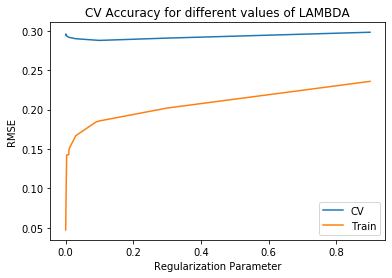

In [18]:
#Plotting a learning curve to visualize the error at different regularization parameters
plt.plot(lambda_params, errors)
plt.plot(lambda_params, train_errors)
plt.ylabel('RMSE')
plt.xlabel("Regularization Parameter")
plt.title("CV Accuracy for different values of LAMBDA")
plt.legend(["CV", "Train"])
plt.show()

In [19]:
#Choosing regularization parameter that minimizes CV error
index = errors.index(min(errors))
lambda_ = lambda_params[index]
lambda_

0.1

#### Choosing the optimal number of iterations (epochs)

This is simply the number of times the algorithm will update the parameters to find the optimal value for the same.

The learning rate and number of iterations go hand in hand. A small learning rate would require a larger number of iterations for the algorithm to converge and a larger learning rate will require a smaller number of iterations to converge.

In [20]:
#Evaluating the performance of the algorithm at different number of iterations

epochs_params = [i for i in range(5, 70, 5)]
errors = []

for i in epochs_params:
    algo = SVD(n_epochs = i, lr_all = alpha, reg_all = lambda_)
    algo.fit(trainset)
    
    #Testing the algorithm on the cross validation sets using 5 fold cross validation
    results = cross_validate(algo, validset, measures=['RMSE'], cv=5, verbose=False)
    results = results["test_rmse"]
    avgError = 0
    for value in results:
        avgError = avgError + value
    avgError = avgError / 5
    
    errors.append(avgError)

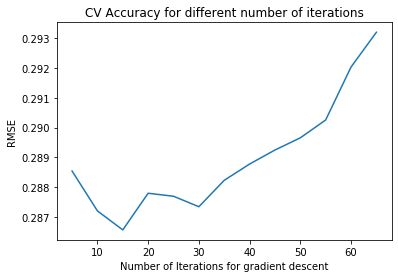

In [21]:
#Visualizing the error at different number of iterations
plt.plot(epochs_params, errors)
plt.ylabel('RMSE')
plt.xlabel("Number of Iterations for gradient descent")
plt.title("CV Accuracy for different number of iterations")
plt.show()

In [22]:
#finalizing the number of iterations
index = errors.index(min(errors))
epochs = epochs_params[index]
epochs

15

Now we have chosen the hyperparameter values that minimizes cross validation error.

In [23]:
#Reporting all hte parameters that will be used when training our final model
print("Hyperparameters that will be applied to test set : ")
print("Learning Rate (Alpha) :", alpha)
print("Regularization Parameter (Lambda) :", lambda_)
print("Optimal number of iterations for convergence :", epochs)

Hyperparameters that will be applied to test set : 
Learning Rate (Alpha) : 0.03
Regularization Parameter (Lambda) : 0.1
Optimal number of iterations for convergence : 15


## Reporting Testset Accuracy when using SVD

Test set accuracy for SVD using manual parameter selection

In [24]:
algo = SVD(n_epochs = epochs, lr_all = alpha, reg_all = lambda_)
algo.fit(trainset)
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

print("RMSE for TestSet :", rmse)

RMSE: 0.2652
RMSE for TestSet : 0.26520133717284256


#### We get an RMSE of about 0.265 (may vary due to random initialization of train and test sets) which corresponds to an MSE of 0.070. 

This is a not a very good result considering the scale of the ratings. This result could be due to the fact that the User-Item matrix is extremely sparse (only about 0.088% of the values are present. This means we have only about 1 rating in every 1000 cells).

One way to confirm this hypothesis is to plot learning curves between the CV error and the number of training examples used, and vary the number of training examples at each iteration. If the error decreases with an increasing number of examples, then we can assume that our hypothesis is correct. Note that when we fit the model to a smaller amount of training data, we are not eliminating the users or the items, we are only eliminating the ratings. In essense, the User-Item matrix remains the same but the dataset becomes more sparse.

The hyperparameters of the model have already been tuned for the best results and hence there is no point spending more time on this aspect of the model to improve the results. We know this because we have already plotted the learning curves for the hyperparameters and inferred the best ones from it. This can also be confirmed by running the model on a smaller subset of the data that is not as sparse as the whole dataset, and you will notice that the results are a lot better compared to the sparse data. Hence we can infer that the choice of parameters are satisfactory.

In the next section we will plot learning curves between the RMSE and trainset size.

In [25]:
#Retrieving the dataframe of train set so we can select fractions of data to train
train_dataframe = trainset.build_testset()
train_dataframe = pd.DataFrame(train_dataframe)
train_dataframe.columns = ['User_Name', 'Game_Name', 'Rating']
train_dataframe.head()

,User_Name,Game_Name,Rating
0,User 293,Red Dead Redemption 2,1.0
1,User 293,Journey,0.9
2,User 293,Bloodborne,1.0
3,User 293,The Witcher 3: Wild Hunt,0.9
4,User 293,Apex Legends,0.9


In [26]:
train_size = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
errors = []
train_errors = []

for i in train_size:
    #selecting the fraction of data to train
    train_frac = train_dataframe.sample(frac = i)
    
    #reading the data in a format suitable for surprise 
    train_frac = Dataset.load_from_df(train_frac[['User_Name', 'Game_Name', 'Rating']], reader)
    
    #Converting the data into a surprise trainset
    train_frac = train_frac.build_full_trainset()
    
    #training the model
    algo = SVD(n_epochs = epochs, lr_all = alpha, reg_all = lambda_)
    algo.fit(train_frac)
    
    #converting the training data into surprise testset format so we can test the training data
    train_frac = train_frac.build_testset()
    
    #testing the training data
    train_predictions = algo.test(train_frac)
    train_errors.append(accuracy.rmse(train_predictions))
    
    #testing the test data
    results = algo.test(testset)
    errors.append(accuracy.rmse(results))

RMSE: 0.1709
RMSE: 0.3040
RMSE: 0.1780
RMSE: 0.2966
RMSE: 0.1882
RMSE: 0.2972
RMSE: 0.1898
RMSE: 0.2920
RMSE: 0.1909
RMSE: 0.2910
RMSE: 0.1943
RMSE: 0.2885
RMSE: 0.1977
RMSE: 0.2885
RMSE: 0.1986
RMSE: 0.2898
RMSE: 0.2008
RMSE: 0.2876
RMSE: 0.2069
RMSE: 0.2848
RMSE: 0.2110
RMSE: 0.2799
RMSE: 0.2165
RMSE: 0.2766
RMSE: 0.2167
RMSE: 0.2741
RMSE: 0.2180
RMSE: 0.2723
RMSE: 0.2210
RMSE: 0.2703
RMSE: 0.2220
RMSE: 0.2698
RMSE: 0.2227
RMSE: 0.2677
RMSE: 0.2261
RMSE: 0.2663
RMSE: 0.2250
RMSE: 0.2640


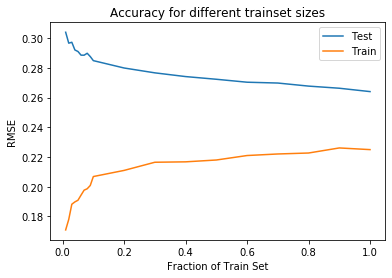

In [27]:
plt.plot(train_size, errors)
plt.plot(train_size, train_errors)
plt.ylabel('RMSE')
plt.xlabel("Fraction of Train Set")
plt.title("Accuracy for different trainset sizes")
plt.legend(["Test", "Train"])
plt.show()

As we can see from the graph above, initially there is a low train error and high test error when the training set is small. This is because as the number of points decreases, it becomes easier to fit the model. Hence, the training error should increase with an increase in the amount of data as seen above. 

As the training size increases, the graph indicates that our data should also be able to generelize well to new data, and hence the test set error decreases athough the train error increases. The train and test accuracy should eventually converge as we get more data from the users. 

#### This confirms our hypothesis that we require more data to make more accurate predictions.

In contrast, if the train and test errors had already converged by now, then obtaining more data would not improve the model.

Lastly, it is worth noting that the decrease in test set error is usually more profound in comparison to this graph. The decrease in test set error is not very prominent in this case because the maximum train set size is not very large to begin with. Also, the data is heavily skewed towards users who have only provided very few ratings and this would also decrease the effects. Again, carrying out this same operation on a subset of this dataset that is not very sparse should confirm this.

# Top-n Predictions using SVD

Now that we have finished training and testing the model with the best parameters, it is time to apply it to check the recommendations made to our user. 

For this we first have to build the set that contains every combination of ratings between the user and the games. 
After this we choose the top 10 predictions and store it in a dataframe to be displayed.

I have not run these lines of code here on the final dataset since it is too large and is not easily handled by my device.

In [ ]:
#Making predictions on all the users after building the whole user-item dataframe
ratings = trainset.build_anti_testset()
predictions = algo.test(ratings)

In [ ]:
#Function that can be used to return the top_n recommendations
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#Getting top 10 game predictions for each user
top_n = get_top_n(predictions, n=10)

In [ ]:
#Converting the recommendations into a dataframe and displaying it
user_recommendations = pd.DataFrame(top_n)
user_recommendations.head()

# Baseline Alternating Least Squares (ALS) using GridSearchCV()

This section will demonstrate an implementation of collaborative filtering using ALS under the BaselineOnly class of the Surprise Package.

In [28]:
#Importing essential libraries
from surprise import BaselineOnly

For this algorithm, I will be using the same train-test splits that we used for SVD as this will allow me to compare the results obtained from the two methods. 

The ALS algorithm has 3 hyperparameters that we can tweat to arrive at optimal results:

reg_u : regularization parameter for users

reg_i : regularization parameter for items

n_epochs : number of iterations the algorithm will run for


I will be using GridSearchCV() to find the optimal combination of hyperparameters.

In [ ]:
#Setting up the range of hyperparameters
param_grid = {
    'bsl_options' : {
        'method' : ['als'],
        'reg_u' : [0.03, 0.09, 0.1, 0.3, 0.9, 1, 3, 9],
        'reg_i' : [0.03, 0.09, 0.1, 0.3, 0.9, 1, 3, 9],
        'n_epochs' : [15, 20, 25]
    }
}

#Finding the optimal combination of parameters
gs_als = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3)
gs_als.fit(train_valid)

In [30]:
print("Best Cross Validation RMSE :", gs_als.best_score['rmse'])
print("Parameters that provide best RMSE :", gs_als.best_params['rmse'])

Best Cross Validation RMSE : 0.3376933716525732
Parameters that provide best RMSE : {'bsl_options': {'method': 'als', 'reg_u': 3, 'reg_i': 3, 'n_epochs': 15}}


## Reporting Testset accuracy for ALS

Test set accuracy for ALS using GridSearchCV()

In [31]:
#Retraining the algorithm with the optimal parameters
als_algo = gs_als.best_estimator['rmse']
als_algo.fit(trainset)

#Retrieving testset error and displaying it
als_predictions = als_algo.test(testset)
als_rmse = accuracy.rmse(als_predictions)

print("RMSE for TestSet using GridSearchCV :", als_rmse)

Estimating biases using als...
RMSE: 0.2609
RMSE for TestSet using GridSearchCV : 0.26092382041528167


#### In this case we get an RMSE of 0.26 which corresponds to an MSE of 0.0676, which is slighty better than the result we obtained from SVD.

However, this is not very surprising since ALS is known to perform slighty better than Stochastic Gradient Descent (which is used in SVD) when dealing with extremely sparse datasets. The difference could be more prominent if we had modified the train-test splits to incorporate a cold-start scenario. 

These are the only matrix factorization based algorithms I will be working with for this dataset. Next, I will be testing a deep learning approach using keras embedding layers and comparing the results. This will be included in another notebook in the repo.